#All imports we need

In [ ]:
import pandas as pd
import re
import nltk
import pandas 
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
!pip install textblob
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

##Data loading

In [ ]:
!wget https://github.com/curso-iabd-uclm/machinelearning/raw/main/insurance/train.csv

--2022-01-22 15:49:24--  https://github.com/curso-iabd-uclm/machinelearning/raw/main/insurance/train.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/curso-iabd-uclm/machinelearning/main/insurance/train.csv [following]
--2022-01-22 15:49:25--  https://raw.githubusercontent.com/curso-iabd-uclm/machinelearning/main/insurance/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4942050 (4.7M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   4.71M  --.-KB/s    in 0.02s   

2022-01-22 15:49:25 (215 MB/s) - ‘train.csv’ saved [4942050/4942050]



In [ ]:
df = pd.read_csv("train.csv")
df

,ClaimNumber,DateTimeOfAccident,DateReported,Age,Gender,MaritalStatus,DependentChildren,DependentsOther,WeeklyWages,PartTimeFullTime,HoursWorkedPerWeek,DaysWorkedPerWeek,ClaimDescription,InitialIncurredCalimsCost,UltimateIncurredClaimCost
0,WC8205482,2002-04-09T07:00:00Z,2002-07-05T00:00:00Z,48,M,M,0,0,500.00,F,38.0,5,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,1500,4748.203388
1,WC6922469,1999-01-07T11:00:00Z,1999-01-20T00:00:00Z,43,F,M,0,0,509.34,F,37.5,5,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5500,6326.285819
2,WC5442654,1996-03-25T00:00:00Z,1996-04-14T00:00:00Z,30,M,U,0,0,709.10,F,38.0,5,CUT ON SHARP EDGE CUT LEFT THUMB,1700,2293.949087
3,WC9796897,2005-06-22T13:00:00Z,2005-07-22T00:00:00Z,41,M,S,0,0,555.46,F,38.0,5,DIGGING LOWER BACK LOWER BACK STRAIN,15000,17786.487170
4,WC2603726,1990-08-29T08:00:00Z,1990-09-27T00:00:00Z,36,M,M,0,0,377.10,F,38.0,5,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,2800,4014.002925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36171,WC5624756,1996-05-29T09:00:00Z,1996-06-27T00:00:00Z,20,F,S,0,0,344.16,F,40.0,5,WALKED INTO DOOR BRUISED LEFT KNEE PAIN,1400,1343.054886
36172,WC8516685,2002-10-08T08:00:00Z,2003-02-07T00:00:00Z,35,M,M,0,0,1668.83,F,71.0,7,LIFTING HOT WATER FROM TRAY BURN LEFT WRIST,1000,172876.632600
36173,WC6891668,1999-09-22T09:00:00Z,1999-11-11T00:00:00Z,52,F,M,0,0,204.87,P,20.0,4,REMOVING BROKEN GLASS LACERATED LEFT THUMB,500,632.281472
36174,WC4287842,1993-02-05T06:00:00Z,1993-03-19T00:00:00Z,28,M,M,0,0,730.87,F,38.0,5,FELL OVER SPRAINED ANKLE AND KNEE INJURY,4000,6714.495760


##Preprocessing

Once we have downloaded train.csv, the first thing we are going to do is to remove the null values from this file.

In [ ]:
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)

The next step is to transform the categorical features into numerical features.

In [ ]:
df_OneHot = pd.get_dummies(df[['Gender','MaritalStatus', 'PartTimeFullTime']])

In [ ]:
df_full = pd.concat([df, df_OneHot], axis = 1)

##Feature selection

For the feature selection we decided to exclude categorical, text-based and date-based features. In this context they are **'Gender', 'MaritalStatus', 'PartialFullTime', 'DateReported', 'DateTimeOfAccident', 'ClaimNumber', 'PartTimeFullTime'.** However, in this part of the task we will keep **'ClaimDescription'** feature due to we will work with it in the next steps

In [ ]:
exclude = ['Gender', 'MaritalStatus', 'PartialFullTime', 'DateReported', 'DateTimeOfAccident', 'ClaimNumber', 'PartTimeFullTime']
df_feature_selected = df_full.loc[:, df_full.columns.difference(exclude)]
df_feature_selected

,Age,ClaimDescription,DaysWorkedPerWeek,DependentChildren,DependentsOther,Gender_F,Gender_M,Gender_U,HoursWorkedPerWeek,InitialIncurredCalimsCost,MaritalStatus_M,MaritalStatus_S,MaritalStatus_U,PartTimeFullTime_F,PartTimeFullTime_P,UltimateIncurredClaimCost,WeeklyWages
0,48,LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY,5,0,0,0,1,0,38.0,1500,1,0,0,1,0,4748.203388,500.00
1,43,STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...,5,0,0,1,0,0,37.5,5500,1,0,0,1,0,6326.285819,509.34
2,30,CUT ON SHARP EDGE CUT LEFT THUMB,5,0,0,0,1,0,38.0,1700,0,0,1,1,0,2293.949087,709.10
3,41,DIGGING LOWER BACK LOWER BACK STRAIN,5,0,0,0,1,0,38.0,15000,0,1,0,1,0,17786.487170,555.46
4,36,REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...,5,0,0,0,1,0,38.0,2800,1,0,0,1,0,4014.002925,377.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36171,20,WALKED INTO DOOR BRUISED LEFT KNEE PAIN,5,0,0,1,0,0,40.0,1400,0,1,0,1,0,1343.054886,344.16
36172,35,LIFTING HOT WATER FROM TRAY BURN LEFT WRIST,7,0,0,0,1,0,71.0,1000,1,0,0,1,0,172876.632600,1668.83
36173,52,REMOVING BROKEN GLASS LACERATED LEFT THUMB,4,0,0,1,0,0,20.0,500,1,0,0,0,1,632.281472,204.87
36174,28,FELL OVER SPRAINED ANKLE AND KNEE INJURY,5,0,0,0,1,0,38.0,4000,1,0,0,1,0,6714.495760,730.87


#3. Improvements

In order to consider other options, now we will take into account **'ClaimDescription'**, which is a **text-based feature**. To do that, a **preprocessing** step needs to be done, then we will use **TF-IDF** vectorizer and TF-IDF vectorizer with **n-grams** as input of a **Random Forest Regressor**.

##Preprocessing ClaimDescription text

We remove all **capital letters**

In [ ]:
df_feature_selected["ClaimDescription"] = df_feature_selected["ClaimDescription"].apply(lambda elem: elem.lower())

We remove **repeated words**

In [ ]:
df_feature_selected["ClaimDescription"] = df_feature_selected["ClaimDescription"].apply(lambda elem: re.sub(r'\b(\w+)( \1\b)+', r'\1', elem))

We remove **stopwords** using nltk

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stopwords = set(stopwords.words("english"))

def remove_stop_words(text):
  text_without_stopwords = ""
  tokens = word_tokenize(text)
  words_without_stopwords = [w for w in tokens if not w in stopwords]
  for word in words_without_stopwords:
    text_without_stopwords = text_without_stopwords + word + " "
  return text_without_stopwords

df_feature_selected["ClaimDescription"] = df_feature_selected["ClaimDescription"].apply(lambda elem: remove_stop_words(elem))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


We **lemmatize** all terms using WordNetLemmatizer

In [ ]:
nltk.download('wordnet')

lemmatizer=WordNetLemmatizer()

def lemmatizerAux(words):
  lemmatized_words = ""
  tokenized_words = word_tokenize(words)
  for word in tokenized_words:
    v_lemmatized_word = lemmatizer.lemmatize(word, pos = 'v')
    lemmatized_words = lemmatized_words + " " + lemmatizer.lemmatize(v_lemmatized_word, pos = 'n')
  return lemmatized_words

df_feature_selected["ClaimDescription"] = df_feature_selected["ClaimDescription"].apply(lambda elem: lemmatizerAux(elem))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


We correct **wrong words** using TextBlob



In [ ]:
def correct_words(text):
  new_doc = TextBlob(text)
  result = new_doc.correct()
  return str(result)

df_feature_selected["ClaimDescription"] = df_feature_selected["ClaimDescription"].apply(lambda elem: correct_words(elem))

Save the preprocessed dataframe with pickle

In [ ]:
df_feature_selected.to_pickle('./preprocessed.pkl')

In [ ]:
df_feature_selected = pd.read_pickle('./preprocessed.pkl')

###TF-IDF vectorizer

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)
output_tfidf = vectorizer.fit_transform(df_feature_selected["ClaimDescription"].tolist())

cv_dataframe=pandas.DataFrame(output_tfidf.toarray(), columns=vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


##Regression

We **split** the output of the tf-idf vectorizer in train (70%) and test (30%)

In [ ]:
X = cv_dataframe#output_tfidf
y = df['UltimateIncurredClaimCost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [ ]:
#1.1 Model Parametrization 
regressor = RandomForestRegressor(n_estimators= 4, max_depth = 2, criterion='mae', random_state=0)
#1.2 Model construction
regressor.fit(X_train, y_train)

# Test
y_pred = regressor.predict(X_test)

# metrics calculation 
mae = mean_absolute_error(y_test,y_pred)
print ("Error Measure ",  mae)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


Error Measure  9407.971663936332


We visualize the results

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


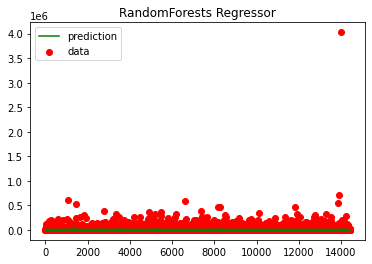

In [ ]:
xx = np.stack(i for i in range(len(y_test)))
plt.scatter(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressor")

plt.show()

Once Random Forest Regressor is done with ClaimDescription feature, we are going to a TFIDF **vectorizer** **with** **n-grams** for ClaimDescription feature, perform a feature selection for TFIDF output with **SelectKBest** and execute **Random Forest Regressor** with the selected features.

###TFIDF + N-GRAM

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=200)
#vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True)

output_tfidf_ngrams = vectorizer.fit_transform(df_feature_selected["ClaimDescription"].tolist())

df_output_tfidf_ngrams=pandas.DataFrame(output_tfidf_ngrams.toarray(), columns=vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df_output_tfidf_ngrams.to_pickle('./tfidf_ngrams.pkl')

###Feature selection with SelectKBest

We select the best 30% of all features in the tfidf vectorizer with n-grams output

In [ ]:
selector = SelectKBest(score_func=f_regression,k=round((df_output_tfidf_ngrams.shape[1] * 30)/100))
output_tfidf_ngrams_new = selector.fit_transform(output_tfidf_ngrams, df_feature_selected["UltimateIncurredClaimCost"])

We convert the **output** of the KBest selector, the **selected features **into a pandas **dataframe**

In [ ]:
selected_indexes = selector.get_support()
selected_columns = []
column_names = df_output_tfidf_ngrams.columns
dataframes = []
for i in range(df_output_tfidf_ngrams.shape[1]):
  if selected_indexes[i] == True:
    aux = []
    aux.append(df_output_tfidf_ngrams.iloc[:,i].tolist())

    dataframes.append(pd.DataFrame(aux, [column_names[i]]).transpose())

selected_features = pd.concat(dataframes, axis=1)

###Regression

In [ ]:
X = selected_features
y = df_full['UltimateIncurredClaimCost']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [ ]:
#1.1 Model Parametrization 
regressor = RandomForestRegressor(n_estimators= 4, max_depth = 2, criterion='mae', random_state=0)
#1.2 Model construction
regressor.fit(X_train, y_train)

# Test
y_pred = regressor.predict(X_test)

# metrics calculation 
mae = mean_absolute_error(y_test,y_pred)
print ("Error Measure ",  mae)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:407: FutureWarning: Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
  FutureWarning,


Error Measure  8884.372296938034


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


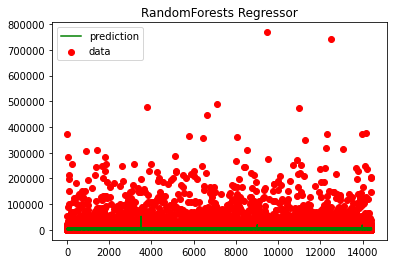

In [ ]:
xx = np.stack(i for i in range(len(y_test)))
plt.scatter(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressor")

plt.show()

#Conclusions

As we have seen in this part of the task, not only **numerical features** are useful in order to develop a regression model. **Text-based features** can **contribute** notably to this process. However, to use this kind of features, a **preprocess step** needs to be done because text may content useless information, misspelled words, etc. Furthermore, we have to use a **TF-IDF vectorizer** to ensure a **valid input** for the regression model. 